# <span style="color:yellow"> Start up and connect to a Spark Cluster </span>
A new cluster will be started if no cluster exists. Otherwise, let's use the existing one

In [5]:
%local
from aws.finspace.cluster import FinSpaceClusterManager

# if this was already run, no need to run again
if 'finspace_clusters' not in globals():
    finspace_clusters = FinSpaceClusterManager()
    finspace_clusters.auto_connect()

cluster_id = finspace_clusters.get_connected_cluster_id()
print(f'connected to cluster: {cluster_id}')

Cluster is starting. It will be operational in approximately 8 to 12 minutes
Starting cluster with cluster ID: v25snxim and state: STARTING
.....................................................................................................................................................................................................................Connecting to cluster.
cleared existing credential location
Persisted krb5.conf secret to /etc/krb5.conf
re-establishing connection...
Persisted keytab secret to /home/sagemaker-user/livy.keytab
Authenticated to Spark cluster
Persisted sparkmagic config to /home/sagemaker-user/.sparkmagic/config.json
Started Spark cluster with clusterId: v25snxim
finished reloading all magics & configurations
Persisted finspace cluster connection info to /home/sagemaker-user/.sparkmagic/finspace_connection_info.json


connected to cluster: v25snxim


In [6]:
#%local
#import pandas as pd
#pd.DataFrame.from_dict( finspace_clusters.list()['clusters'] ) 

Starting Spark session


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1657138234953_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# <span style="color:yellow"> Set dataset and view </span>
The demo uses the dataset: "US Equity TAQ Sample - AMZN 6 Months - Sample". A user needs to replace the values of the 2 parameters with what are shown in finspace

In [7]:
#%local 
#####----------------------------------------------------------
##### Place to change
##### REPLACE WITH CORRECT IDS!
##### Dataset: "US Equity TAQ Sample - AMZN 6 Months - Sample"
#####
#####----------------------------------------------------------

dataset_id = 'lognuf1'
view_id    = 'HMDkXwrvn5urQY898eEGXQ'

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# <span style="color:yellow"> Obtain and process data using FinSpace analytical functions </span>
Import libraries for price pattern analysis (`scipy`), plotting (`matplotlib`), data processing (`pyspark`) and aggregation (`finspace`)

In [8]:
import numpy as np
from scipy.signal import argrelextrema
import os
import matplotlib.pyplot as plt
import matplotlib
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import datetime as dt
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pprint 
from aws.finspace.timeseries.spark.util import string_to_timestamp_micros
from aws.finspace.timeseries.spark.windows import create_time_bars, compute_analytics_on_features, compute_features_on_time_bars
from aws.finspace.timeseries.spark.spec import BarInputSpec, TimeBarSpec
from aws.finspace.timeseries.spark.summarizer import *
from aws.finspace.timeseries.spark.analytics import *
from aws.finspace.timeseries.finance.calendars import *
from aws.finspace.timeseries.spark.prepare import *


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/usr/lib/spark/python/lib/pyspark.zip/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

Call the finspace library function `FinSpaceAnalyticsManager` to obtain the finspace analytics manager

In [9]:
# Initialize and Connect
from aws.finspace.analytics import FinSpaceAnalyticsManager
finspace = FinSpaceAnalyticsManager(spark = spark)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Set the day range for price action analysis 

In [10]:
# Date range
start_date = dt.datetime(2019, 10, 1)
end_date   = dt.datetime(2019, 12, 31)

# debug mode
debug_mode = True

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Read data from the finspace

In [11]:
#tDF = finspace.read_view_as_spark(dataset_id = dataset_id, view_id = view_id)
tDF = finspace.read_data_view(dataset_id = dataset_id, data_view_id = view_id)
if debug_mode:
    tDF.printSchema() 
    tDF.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- timestamp: string (nullable = true)
 |-- eventtype: string (nullable = true)
 |-- ticker: string (nullable = true)
 |-- price: double (nullable = true)
 |-- quantity: long (nullable = true)
 |-- exchange: string (nullable = true)
 |-- conditions: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- date: date (nullable = true)

145933032

Next we decide how to generate "bars" for further technical analysis. We select the bar size to be 1 min because it is normally the highest frequency human traders can process. Further smoothing or aggregation can also be applied to multiple bars in a flexible and user configurable way.

In [12]:
bw = '1 minute'

# what columns to collect in the bar - fixed
bar_input_spec = BarInputSpec('activity', 'datetime', 'timestamp', 'price', 'quantity', 'exchange', 'conditions' )
# timebar column name - fixed
timebar_col = 'window'
# group the dataset's values by....
partitionList = ["ticker", "eventtype"]
# ticker and trade event for which the trading sign is defined. 
fTicker = 'AMZN'
event_type = 'TRADE NB'

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Call `finspace` library to generate bars in the form of spark dataframe. Then several number technical indicators (e.g. `std`, `vwap`, `ohlc`, `volume`) are generated using the library functions. Finally, we only select trading data within the analysis window

In [13]:
timebar_spec   = TimeBarSpec(timestamp_column='datetime', window_duration=bw, slide_duration=bw)
bar_input_spec = BarInputSpec('activity', 'datetime', 'timestamp', 'price', 'quantity', 'exchange', 'conditions' )
collDF = create_time_bars(data = tDF, 
                         timebar_column = timebar_col, 
                         grouping_col_list = ['date', 'ticker', 'eventtype'], 
                         input_spec = bar_input_spec, 
                         timebar_spec = timebar_spec)\
            .withColumn( 'activity_count', F.size( F.col('activity') ) )
# free up DF
tDF.unpersist()

sumDF = ( collDF
        .withColumn( 'std',    std( 'activity.price' ) )
        .withColumn( 'vwap',   vwap( 'activity.price', 'activity.quantity' ) )
        .withColumn( 'ohlc',   ohlc_func( 'activity.datetime', 'activity.price' ) ) 
        .withColumn( 'volume', total_volume( 'activity.quantity' ) )        
        .drop( collDF.activity )
    )
# free up DF
collDF.unpersist()

ffDF = time_bar_fill_and_filter(sumDF, timebar_col, NYSECalendar20192020(), timebar_spec, start_date, end_date, fill_value=np.nan)
# free up DF
sumDF.unpersist()

tsDF = ( ffDF        
        .filter(ffDF.date.between(start_date, end_date))
        .filter(ffDF.eventtype==event_type)
        # flatten window
        .withColumn("start", ffDF.window.start)
        .withColumn("end",   ffDF.window.end)
        .drop("window")
        # flatten ohlc
        .withColumn("open",  ffDF.ohlc.open)
        .withColumn("high",  ffDF.ohlc.high)
        .withColumn("low",   ffDF.ohlc.low)
        .withColumn("close", ffDF.ohlc.close)
        .drop("ohlc")
        # order 
        .orderBy("ticker", "eventtype", "start")
    )
# free up DF
ffDF.unpersist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[window: struct<start:timestamp,end:timestamp>, date: date, ticker: string, eventtype: string, activity_count: int, std: double, vwap: double, ohlc: struct<open:double,high:double,low:double,close:double>, volume: double]

In [14]:
tsDF.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

7066

# <span style="color:yellow"> Further smooth close price to reduce noise in head-shoulder pattern detection </span>

Smoothing is usually needed to reduce the noise in price action pattern identification. This demo chooses to smooth the close price using exponential moving average of past 5 bars. Finally, only 3 columns of the dataframe are kept: the start time and close price of each bar, and the smoothed close price

Note the smoothing can be combined with bar generation but in order to make the processing more flexible, we decouple them. This also speeds up repeated tests because the bars are generated one time where data size is greatly reduced. Further smoothing is only applied to the resultant smaller dataset of 1-min bars. 

In [15]:
# 5-bars
win=5
smoothing = exponential_moving_average(win, "start", "close")

# group the sets of values. Note need to partition by date to prevent the window spreading cross the day
partitionList = ["ticker", "eventtype", "date"]

tsDF = compute_analytics_on_features(tsDF, "smoothed_close", smoothing, partition_col_list = partitionList)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/usr/lib/spark/python/lib/pyspark.zip/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

In [16]:
tsDF = (tsDF                
        .withColumn("start", tsDF.start)
        .withColumn("close", tsDF.close)
        .withColumn("smoothed_close", tsDF.smoothed_close)
        # drop everything else
        .drop("date", "ticker", "eventtype", "activity_count", "std", "vwap", "volume", "end", "open", "high", "low")
    ) 
tsDF.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- start: timestamp (nullable = true)
 |-- close: double (nullable = true)
 |-- smoothed_close: double (nullable = true)

# <span style="color:yellow"> Pick a time period to identify head-shoulder patterns </span>
Note: for best visual identification, the period should not be too large. 1 day is chosen for demo purpose

In [17]:
pa_win_start = '2019-10-02 00:00:01'
pa_win_end = '2019-10-02 23:59:59'
tsDF=tsDF.filter(tsDF.start.between(pa_win_start, pa_win_end))
tsDF.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

151

Extract the data within the selected period.

Note `argrelextrema` can't process spark dataframe. Data is passed in as a `numpy` array through pandas dataframe

In [18]:
window_range=3
prices = tsDF.toPandas()[['start', 'close', 'smoothed_close']].set_index('start')
smooth_prices = prices['smoothed_close'].dropna()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# <span style="color:yellow"> Find head-shoulders using local maxmins </span>

Scipy function `argrelextrema` is used for this purpose. Then we perform further smoothing by picking minima and maxima out of a window: the local minima/maxima must be the minimum/maximum within the window of 7 bars centered on itself. This helps dampen noise when dealing with volatile time series.


In [19]:
import pandas as pd
local_max = argrelextrema(smooth_prices.values, np.greater)[0]
local_min = argrelextrema(smooth_prices.values, np.less)[0]
price_local_max_dt = []
for i in local_max:
    if (i>window_range) and (i<len(prices)-window_range):
        price_local_max_dt.append(prices['close'].iloc[i-window_range:i+window_range].idxmax())
price_local_min_dt = []
for i in local_min:
    if (i>window_range) and (i<len(prices)-window_range):
        price_local_min_dt.append(prices['close'].iloc[i-window_range:i+window_range].idxmin())  

maxima = pd.DataFrame(prices.close.loc[price_local_max_dt])
maxima['type'] = ['max']*maxima.shape[0]

minima = pd.DataFrame(prices.close.loc[price_local_min_dt])
minima['type'] = ['min']*minima.shape[0]
max_min = pd.concat([maxima, minima]).sort_index()
max_min.index.name = 'winstart'
#max_min = max_min.reset_index()
max_min.head(30)

is_duplicate = max_min.index.duplicated(keep="first")
not_duplicate = ~is_duplicate
max_min=max_min.loc[not_duplicate]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

A head-shoulder pattern is identified by 5 points where 
* The 1st, 3rd and 5th are the local maxima and 2nd and 4th the minima
* The total time span from 1st point to the last must be within a limit. Otherwise the pattern is of little value for trading purposes. In our demo, we use parameter max_unit and unit to specify the limit, e.g. 2 hours.
* The neckline in the most typical head-shoulder patterns is normally flat, i.e. 2nd and 4th points are close. We hardcode (for simplicity) a small tolerance level (0.015 of the mean value of the two minima).

The above 3 conditions are checked for all identified local minima and maxima to identify the patterns. 

In [20]:
#%% define functions
def find_patterns(max_min, max_unit, unit):  
    patterns = defaultdict(list)
    
    max_span = pd.Timedelta(max_unit, unit)
    for i in range(5, len(max_min)):  
        window = max_min.iloc[i-5:i]
        
        ## Pattern must play out in less than n units
        if window.index[-1] - window.index[0] > max_span:      
           continue   
            
        E = window.iloc[0:5].close
                
        # IHS
        if E[0]<E[1] and E[2]<E[0] and E[2]<E[4] and E[4]<E[3] and abs(E[1]-E[3])<=np.mean(E[[1,3]])*0.015:
            patterns['IHS'].append((window.index[0], window.index[-1]))
        # HS: E1, E3 and E5 are the maximas 
        if E[0]>E[1] and E[2]>E[0] and E[2]>E[4] and E[4]>E[3] and abs(E[1]-E[3])<=np.mean(E[[1,3]])*0.015:
            patterns['HS'].append((window.index[0], window.index[-1]))
    
    return patterns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
lasti = max_min.index[0]
agg_maxmin = []

for p in max_min.index[1:]:
    if max_min.loc[p].type == max_min.loc[lasti].type:
        if max_min.loc[p].type == 'max' and max_min.loc[p].close > max_min.loc[lasti].close or \
           max_min.loc[p].type == 'min' and max_min.loc[p].close < max_min.loc[lasti].close: 
           lasti = p
    if max_min.loc[p].type != max_min.loc[lasti].type:
        agg_maxmin.append(lasti)
        lasti = p

agg_maxmin.append(lasti)
pat = find_patterns(max_min, 2, unit='H')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# <span style="color:yellow"> Plot head shoulders </span>

In [22]:
print(pat['HS'])
timestamps = lambda dtindex: [f'{t.hour}:{t.minute}:{t.second}' for t in dtindex]

def get_end_point(tindex, xy1, xy2, length=1):
    xrange = tindex.get_loc(xy2[0]) - tindex.get_loc(xy1[0])
    slope = (xy2[1] - xy1[1] )/ xrange
    xe = tindex[tindex.get_loc(xy1[0]) + xrange*length]
    ye = xy1[1] + slope*xrange*length
    #print(f'xe={xe}, ye={ye}, slopt={slope}, xrange={xrange}, length={length}')
    return (xe, ye)            

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(Timestamp('2019-10-02 13:36:00'), Timestamp('2019-10-02 13:44:00')), (Timestamp('2019-10-02 13:46:00'), Timestamp('2019-10-02 14:03:00')), (Timestamp('2019-10-02 15:03:00'), Timestamp('2019-10-02 15:34:00'))]

The identified head-shoulders are plotted. 
* The left and right shoulders and head are red dots. As seen, they are local maxima, of which the head is the largest
* The neck points are in blue. 
* The neckline is the dashline through the two neck points. In this example, the neckline tilts upward.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

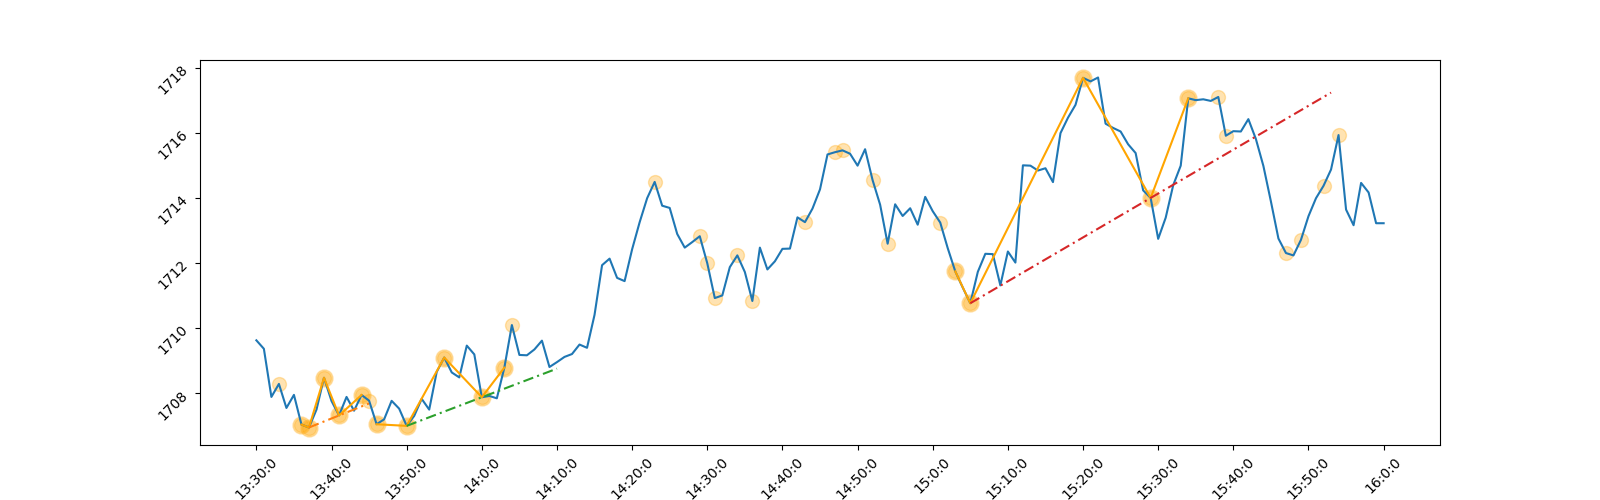

In [23]:
#%% plot max min
f, axes = plt.subplots(1, 1, figsize=(16, 5))
#timestamps = [f'{t.hour}:{t.minute}:{t.second}' for t in prices.index]
axes.plot(timestamps(prices.index), prices['close'])
#axes.plot(smooth_prices)
NT=len(prices['close'].index)
xstep=10
#axes.xaxis.set_ticks(prices['close'].index[range(0, NT, xstep)], rotation=45)
#axes.set_xticklabels(prices['close'].index, rotation=45)
axes.scatter(timestamps(max_min.index), max_min.close, s=100, alpha=.3, color='orange')
axes.xaxis.set_major_locator(plt.MaxNLocator(20))
axes.tick_params(labelrotation=45)

pattern_color={'HS':'orange','IHS':'black'}
for pt in pat.keys():
    for win in pat[pt]:
        w = max_min.loc[win[0]:win[1]]
        axes.scatter(timestamps(w.index), w.close, s=150, marker='o', alpha=.3, color=pattern_color[pt])
        axes.plot(timestamps(w.index), w.close, color=pattern_color[pt])
        (xe, ye) = get_end_point(prices.index, (w.index[1], w.close[1]), (w.index[3], w.close[3]), length=2)
        axes.plot(timestamps([w.index[1], xe]), [w.close[1], ye], dashes= (5, 2, 1, 2))
        #axes.plot((prices.index.get_loc(w.index[1]), w.close[1]), (xe, ye), color='blue', dashes= (5, 2, 1, 2))  
%matplot plt

# <span style="color:yellow"> Clean up </span>
Run after all the tests are done and the cluster is no longer needed. 

In [ ]:
%local 
finspace_clusters.terminate(cluster_id)